# Staff Planning - Optimization

## Problem Statement

The insurance approval process, i.e., underwriting is one of the important and time-consuming tasks in an insurance application processing. When an insurance application is submitted, the underwriter of the company evaluates it based on the details provided by the applicant using a rule-based or an ML model and decides whether or not to approve the application.

An insurance company InsurePlus operates in three states: A, B and C. The company can either handle an application with the staff that they hire or outsource it to a vendor. The company has been able to forecast the state-wise demand for insurance for each month of the year - 2021.

A staff member can handle 40 insurance applications per month when he/she works 100% of the workdays and there is no capacity limitation to outsourcing. A staff member’s availability (in percentage) to work on processing the insurance applications for each month and state has been provided. States A and B have a regulatory restriction that the outsourced insurance applications cannot be more than 30% and 40% of the total number of applications for each month, respectively. 

We have been provided with the data on the annual salary of staff for each state and the outsourcing cost per application in each state.


## Business Objective

An insurance company InsurePlus requires a solution on the optimal number of staff that they need for their insurance application approval process for the calendar year 2021.  In the industry, the number of staffs is considered as a continuous variable. This is also called a Full-Time Equivalent (FTE) of the staff

The objective is to optimise the total cost for the application approval process by distributing the right number of applications between the FTEs and the vendors while meeting the monthly demand for each state at the same time.

In [1]:
# Installing pyomo
!pip install -q pyomo
!apt-get install -y -qq coinor-cbc
!apt-get install -y -qq glpk-utils

     |████████████████████████████████| 9.7 MB 1.2 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 123942 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.10.14+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.10.14+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.107.9+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.107.9+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.16.11+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.16.11+repack1-1) ...
Selecting previously unselected package coinor-libcgl1.
Preparing to unpack .../3-coinor-libcgl1_0.59.10+repack1-1_amd64.deb ...
Unpacking coinor-libcgl1 (0.59.10+repack1-1) ...
Selecting previously unselected package coinor-libcbc3.
Preparing to unp

In [2]:
# Importing Libraries 

import pandas as pd
import numpy as np
import math
from pyomo.environ import *

In [3]:
from __future__ import division
from pyomo.opt import SolverFactory

In [ ]:
from google.colab import drive
drive.mount('/content.drive')

Mounted at /content.drive


In [6]:
# Reading the data from Excel workbook
path = "/content.drive/MyDrive/colab data/Staffing+Data.xlsx"
#staff_data = pd.read_excel(path)

Staff_avail = pd.read_excel(path,sheet_name="StaffAvailability")
Demand = pd.read_excel(path,sheet_name="DemandData")
Cost = pd.read_excel(path,sheet_name="Cost")
Data_dict =pd.read_excel(path,sheet_name="Data Dictionary")
Rate = pd.read_excel(path,sheet_name="ServiceRate")

In [7]:
Staff_avail.head()

,State,Month,LB,UB,StaffAvPer
0,A,Jan,0.70,0.90,0.81
1,A,Feb,0.65,0.85,0.76
2,A,Mar,0.70,0.80,0.75
3,A,Apr,0.75,0.85,0.80
4,A,May,0.70,0.85,0.78


In [8]:
Demand.head()

,State,Month,Demand
0,A,Jan,5240
1,A,Feb,4878
2,A,Mar,5942
3,A,Apr,2297
4,A,May,1992


In [9]:
Cost.head()

,State,Month,AnnualSalary,MonthlySalary,UnitOutSourceCost
0,A,Jan,60000,5000.0,180
1,A,Feb,60000,5000.0,180
2,A,Mar,60000,5000.0,180
3,A,Apr,60000,5000.0,180
4,A,May,60000,5000.0,180


In [10]:
Data_dict.head()

,Column name,Description
0,State,Location of the Bank
1,Month,Month of the year
2,Demand,Number of insurance applications that are expe...
3,StaffAvPer,Average availability of an FTE (Full Time Empl...
4,LB,Minimum availability of an FTE


In [11]:
Rate.head()

,MgAppServedPerMonth
0,40


## Data pre-processing 

In [12]:
# Create the required Python data structures for indexes and parameters

# creating dictionary for demand
Demand_ca = Demand.set_index(['State','Month'])['Demand'].to_dict()

In [13]:
# creating dictionary for Staff_avail_LB - Lower Bound for Staff availability
Staff_LBca =Staff_avail.set_index(['State','Month'])['LB'].to_dict()

In [14]:
# creating dictionary for Staff_avail_UB - Upper bound for Staff availability
Staff_UBca = Staff_avail.set_index(['State','Month'])['UB'].to_dict()

In [15]:
# creating dictionary for StaffAvPer - Average Staff Availability
StaffAvP_ca= Staff_avail.set_index(['State','Month'])['StaffAvPer'].to_dict()

In [16]:
# creating dictionary for Staff - Monthly Salary of the Staff
FTE_MonthSal_ca= Cost.set_index(['State','Month'])['MonthlySalary'].to_dict()

In [17]:
# creating dictionary for unitoutsorce - Cost of outsourcing one application
UnitOutSource_ca= Cost.set_index(['State','Month'])['UnitOutSourceCost'].to_dict()

In [18]:
# Number of applications per employee
AppServeRate_ca= Rate.iloc[0,0]

In [19]:
# Indexes for the Model
BLocation_ca= Cost['State'].unique()
Month_ca= Cost['Month'].unique()

In [20]:
# Company operating locations
BLocation_ca

array(['A', 'B', 'C'], dtype=object)

In [21]:
# List of the 12 months
Month_ca

array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Oct', 'Nov', 'Dec'], dtype=object)

In [22]:
# view salary
FTE_MonthSal_ca

{('A', 'Jan'): 5000.0,
 ('A', 'Feb'): 5000.0,
 ('A', 'Mar'): 5000.0,
 ('A', 'Apr'): 5000.0,
 ('A', 'May'): 5000.0,
 ('A', 'Jun'): 5000.0,
 ('A', 'Jul'): 5000.0,
 ('A', 'Aug'): 5000.0,
 ('A', 'Sep'): 5000.0,
 ('A', 'Oct'): 5000.0,
 ('A', 'Nov'): 5000.0,
 ('A', 'Dec'): 5000.0,
 ('B', 'Jan'): 4583.333333333333,
 ('B', 'Feb'): 4583.333333333333,
 ('B', 'Mar'): 4583.333333333333,
 ('B', 'Apr'): 4583.333333333333,
 ('B', 'May'): 4583.333333333333,
 ('B', 'Jun'): 4583.333333333333,
 ('B', 'Jul'): 4583.333333333333,
 ('B', 'Aug'): 4583.333333333333,
 ('B', 'Sep'): 4583.333333333333,
 ('B', 'Oct'): 4583.333333333333,
 ('B', 'Nov'): 4583.333333333333,
 ('B', 'Dec'): 4583.333333333333,
 ('C', 'Jan'): 4416.666666666667,
 ('C', 'Feb'): 4416.666666666667,
 ('C', 'Mar'): 4416.666666666667,
 ('C', 'Apr'): 4416.666666666667,
 ('C', 'May'): 4416.666666666667,
 ('C', 'Jun'): 4416.666666666667,
 ('C', 'Jul'): 4416.666666666667,
 ('C', 'Aug'): 4416.666666666667,
 ('C', 'Sep'): 4416.666666666667,
 ('C', 'Oc

In [23]:
#Cost of outsourcing one application
UnitOutSource_ca

{('A', 'Jan'): 180,
 ('A', 'Feb'): 180,
 ('A', 'Mar'): 180,
 ('A', 'Apr'): 180,
 ('A', 'May'): 180,
 ('A', 'Jun'): 180,
 ('A', 'Jul'): 180,
 ('A', 'Aug'): 180,
 ('A', 'Sep'): 180,
 ('A', 'Oct'): 180,
 ('A', 'Nov'): 180,
 ('A', 'Dec'): 180,
 ('B', 'Jan'): 150,
 ('B', 'Feb'): 150,
 ('B', 'Mar'): 150,
 ('B', 'Apr'): 150,
 ('B', 'May'): 150,
 ('B', 'Jun'): 150,
 ('B', 'Jul'): 150,
 ('B', 'Aug'): 150,
 ('B', 'Sep'): 150,
 ('B', 'Oct'): 150,
 ('B', 'Nov'): 150,
 ('B', 'Dec'): 150,
 ('C', 'Jan'): 160,
 ('C', 'Feb'): 160,
 ('C', 'Mar'): 160,
 ('C', 'Apr'): 160,
 ('C', 'May'): 160,
 ('C', 'Jun'): 160,
 ('C', 'Jul'): 160,
 ('C', 'Aug'): 160,
 ('C', 'Sep'): 160,
 ('C', 'Oct'): 160,
 ('C', 'Nov'): 160,
 ('C', 'Dec'): 160}

In [24]:
#Demand of insurance per state for each month
Demand_ca

{('A', 'Jan'): 5240,
 ('A', 'Feb'): 4878,
 ('A', 'Mar'): 5942,
 ('A', 'Apr'): 2297,
 ('A', 'May'): 1992,
 ('A', 'Jun'): 2275,
 ('A', 'Jul'): 5334,
 ('A', 'Aug'): 3371,
 ('A', 'Sep'): 3759,
 ('A', 'Oct'): 3529,
 ('A', 'Nov'): 4284,
 ('A', 'Dec'): 5183,
 ('B', 'Jan'): 4927,
 ('B', 'Feb'): 2628,
 ('B', 'Mar'): 2974,
 ('B', 'Apr'): 2338,
 ('B', 'May'): 4020,
 ('B', 'Jun'): 3147,
 ('B', 'Jul'): 4271,
 ('B', 'Aug'): 2620,
 ('B', 'Sep'): 4517,
 ('B', 'Oct'): 4155,
 ('B', 'Nov'): 3137,
 ('B', 'Dec'): 4227,
 ('C', 'Jan'): 1162,
 ('C', 'Feb'): 1967,
 ('C', 'Mar'): 1898,
 ('C', 'Apr'): 2261,
 ('C', 'May'): 2030,
 ('C', 'Jun'): 1642,
 ('C', 'Jul'): 2489,
 ('C', 'Aug'): 2496,
 ('C', 'Sep'): 922,
 ('C', 'Oct'): 2421,
 ('C', 'Nov'): 963,
 ('C', 'Dec'): 1998}

# Question 1

The company wants to know the optimised staffing recommendations for the business case described. 
Write the mathematical model for the deterministic optimisation problem. Define and explain your decision variables, objective function and the constraint. (Hint: Use months of the year as the model timeline).



Parameter

* Demand
* Staff Availability %tage
* FTE Salary / month
*
Unix Outsourcing cost
*
FTE_Application Service Rate
(40 application per month, if 100% staff is working)

Decision Variable:
* FTE Equivalent at any location in a month which is continuous variable
* Outsourced Application Quantity in a month (Integer Variable)

### Decision Variables are:
    
1. Total Number of Staff Members (FTE)

2. Number of Outsourced Members (Vendors)

#### Objective function is:
1. Annual Total cost of FTE
2. Annual Total Cost of Vendors

Minimize Total cost =(1) +(2)

Total Cost = (Total Number of members in Staffs) x (Salary of Staffs) + (Total Number of Outsourced Members) x (Cost of Outsourced members)

N.B.: 40 x StaffAvPer is number of applications of each staff member

#### Constraints
States A and B have a regulatory restriction that the outsourced insurance applications cannot be more than 30% and 40% of the total number of applications for each month, respectively.

Number of Outsourced Members = Number of Outsourced applications


1. Number of Staffs x 40 x (StaffAvailability) + (Number of outsourced members) == Demand

2. For state A :
Number of Outsourced Members <= 0.3 x (Demand)
3. For state B :
Number of Outsourced Members <= 0.4 x (Demand)

**Note:** You can write the mathematical formulation directly in your report.

# Question 2

Code the problem is Python and use any optimization package to solve it. Add comments to your code to explain each step. 

#### Expected output:

Create a data frame containing the number of outsourced applications  and the number of FTEs for each state-month combination. You can choose to have extra columns like staff availability, demand etc. in your dataframe apart from the ones mentioned earlier. 

In [25]:
# Creating a model instance
Model1 =ConcreteModel()

In [26]:
# Define Pyomo sets and Parameters
Model1.i = Set(initialize=BLocation_ca.tolist(), doc='States')
Model1.j = Set(initialize=Month_ca.tolist(), doc='Months')


In [27]:
# Define parameters for demand, FTE salaries, outsourcing cost and Average staff availability

Model1.d = Param(Model1.i, Model1.j, initialize=Demand_ca, doc='Demand')
Model1.s = Param(Model1.i, Model1.j, initialize=FTE_MonthSal_ca, doc='FTE_Salary')
Model1.oc = Param(Model1.i, Model1.j, initialize=UnitOutSource_ca, doc='OutSourceCost')
Model1.sa = Param(Model1.i, Model1.j, initialize=AppServeRate_ca, doc='StaffAvPercent')


In [28]:
Model1.d

In [29]:
#  Scalar Application Service Rate When Working 100 % 

Model1.r = Param(initialize=AppServeRate_ca, doc='FTE App Serv Rate')

In [30]:
#  Parameter for number of applications that can be processed for the given staff availability

def c_FTEAPP(Model1, i, j):
    return Model1.r * Model1.sa[i,j] 

Model1.FTEAPPNO = Param(Model1.i, Model1.j, initialize=c_FTEAPP, doc='NO OF FTE APP')


In [31]:
#  Parameters for the restriction on number of outsourced applications for the states A and B

def Reg_A(Model1, i, j):
    return 0.30 * Model1.d[i,j] 

Model1.Reg_A = Param(Model1.i, Model1.j, initialize=Reg_A, doc='RegRest_A')


def Reg_B(Model1, i, j):
    return 0.40 * Model1.d[i,j] 

Model1.Reg_B = Param(Model1.i, Model1.j, initialize=Reg_B, doc='RegRest_B')

# Define Pyomo sets and Parameters
Demand = (staff_availability) * 40 * (x+y)

FTE_Salary = Staff

Outsource cost = UnitOutSourceCost

Staff availability = 40xStaffAvPer

number of staffs = x

number of outsourced employees = y

In [32]:
# Decision variables
Model1.x = Var(BLocation_ca, Month_ca, within=PositiveReals, initialize=70000)
Model1.y = Var(BLocation_ca, Month_ca, within=PositiveReals, initialize=70000)

In [33]:
# Constraints

# Constraint 1: To meet the state-wise demand for each month 
def demand(Model1,s,m):
    return (Model1.x[s,m]*40*StaffAvP_ca[s,m]+Model1.y[s,m])==Demand_ca[s,m]

In [34]:
Model1.demand = Constraint(BLocation_ca,Month_ca,rule=demand)

In [35]:
#Constraint 2: Maximum of 30% of applications can be outsourced in State A

def outsource_constraint1(Model1,m):
    return (Model1.y['A',m]<=0.3*Demand_ca['A',m])   

In [36]:
Model1.outsource_constraint1 = Constraint(Month_ca,rule=outsource_constraint1)

In [37]:
# Constraint 3: Maximum of 40% of applications can be outsourced in State B

def outsource_constraint2(Model1,m):
  return(Model1.y['B',m]<=0.4*Demand_ca['B',m])

Model1.outsource_constraint2 = Constraint(Month_ca, rule =outsource_constraint2 ) 

In [38]:
# Objective function
Model1.value = Objective(expr = (sum(FTE_MonthSal_ca[s,m]*Model1.x[s,m] for m in Month_ca for s in BLocation_ca)+sum(UnitOutSource_ca[s,m]*Model1.y[s,m] for m in Month_ca for s in BLocation_ca))
 ,sense= minimize)

In [39]:
# Invoking the solver
ca_result = SolverFactory('glpk').solve(Model1)
ca_result.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 17962273.21996
  Upper bound: 17962273.21996
  Number of objectives: 1
  Number of constraints: 61
  Number of variables: 73
  Number of nonzeros: 97
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.0179140567779541
# ----------------------------------------------------------
#   Solution Information
# -----------------

In [40]:
# Print the value of the objective function
int(Model1.value())

17962273

Obtained the total cost of application processing as 17.96 M$ after optimization for Average scenario.

In [41]:
# Printing the results of the Solver
Model1.pprint()

20 Set Declarations
    FTEAPPNO_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    i*j :   36 : {('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), ('A', 'Dec'), ('B', 'Jan'), ('B', 'Feb'), ('B', 'Mar'), ('B', 'Apr'), ('B', 'May'), ('B', 'Jun'), ('B', 'Jul'), ('B', 'Aug'), ('B', 'Sep'), ('B', 'Oct'), ('B', 'Nov'), ('B', 'Dec'), ('C', 'Jan'), ('C', 'Feb'), ('C', 'Mar'), ('C', 'Apr'), ('C', 'May'), ('C', 'Jun'), ('C', 'Jul'), ('C', 'Aug'), ('C', 'Sep'), ('C', 'Oct'), ('C', 'Nov'), ('C', 'Dec')}
    Reg_A_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    i*j :   36 : {('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), ('A', 'Dec'), ('B', 'Jan'), ('B', 'Feb'), (

**`Checkpoint 1:`** Seems like the company has to spend around 17.9 m$ in total for the application approval process.

In [42]:
# Creating dataframe for the results
Output = []
# For every iteration, code below will create a list containing the values of state, month, number of staff, outsourced and
# cost for those parameters

for s in BLocation_ca:
    for m in Month_ca:
        
        #Number of calls to be made for each segment
        staff=Model1.x[s,m].value
        
        #converted calls
        outsource=Model1.y[s,m].value
        
        Total_monthly_cost=Model1.x[s,m].value*FTE_MonthSal_ca[s,m]+Model1.y[s,m].value*UnitOutSource_ca[s,m]
        
        staff_Appl = Model1.x[s,m].value * 40 * StaffAvP_ca[s,m]
        
        Demand_col = Demand_ca[s,m]
        
        Per_Appl_cost = (FTE_MonthSal_ca[s,m]/40) + UnitOutSource_ca[s,m]
        
       
        Staff_cost=FTE_MonthSal_ca[s,m]
        Outsource_cost=UnitOutSource_ca[s,m]
        
        Output.append([s,m,staff,outsource,Total_monthly_cost,staff_Appl,Demand_col,Per_Appl_cost,Staff_cost,Outsource_cost])
        
print(Output)


[['A', 'Jan', 161.728395061728, 0.0, 808641.97530864, 5239.999999999987, 5240, 305.0, 5000.0, 180], ['A', 'Feb', 160.460526315789, 0.0, 802302.631578945, 4877.999999999985, 4878, 305.0, 5000.0, 180], ['A', 'Mar', 198.066666666667, 0.0, 990333.333333335, 5942.000000000011, 5942, 305.0, 5000.0, 180], ['A', 'Apr', 71.78125, 0.0, 358906.25, 2297.0, 2297, 305.0, 5000.0, 180], ['A', 'May', 63.8461538461538, 0.0, 319230.76923076896, 1991.9999999999986, 1992, 305.0, 5000.0, 180], ['A', 'Jun', 77.9109589041096, 0.0, 389554.794520548, 2275.0000000000005, 2275, 305.0, 5000.0, 180], ['A', 'Jul', 137.272058823529, 1600.2, 974396.294117645, 3733.7999999999893, 5334, 305.0, 5000.0, 180], ['A', 'Aug', 110.888157894737, 0.0, 554440.7894736851, 3371.0000000000055, 3371, 305.0, 5000.0, 180], ['A', 'Sep', 116.018518518519, 0.0, 580092.592592595, 3759.000000000016, 3759, 305.0, 5000.0, 180], ['A', 'Oct', 120.856164383562, 0.0, 604280.82191781, 3529.0000000000105, 3529, 305.0, 5000.0, 180], ['A', 'Nov', 110

In [43]:
# Transforming into a dataframe and renaming the columns of the dataframe
Output_ca = pd.DataFrame(Output,columns=['State', 'Month','Number of Staffs','Number of Outsource','Total Monthly Cost',
                                      'Staff Applications','Demand','Per Application Cost','Staff Cost','Outsource cost'])

In [44]:
# Dataframe representing the output of the Solver along with additiona metrics
Output_ca

,State,Month,Number of Staffs,Number of Outsource,Total Monthly Cost,Staff Applications,Demand,Per Application Cost,Staff Cost,Outsource cost
0,A,Jan,161.728395,0.0,808641.975309,5240.0,5240,305.000000,5000.000000,180
1,A,Feb,160.460526,0.0,802302.631579,4878.0,4878,305.000000,5000.000000,180
2,A,Mar,198.066667,0.0,990333.333333,5942.0,5942,305.000000,5000.000000,180
3,A,Apr,71.781250,0.0,358906.250000,2297.0,2297,305.000000,5000.000000,180
4,A,May,63.846154,0.0,319230.769231,1992.0,1992,305.000000,5000.000000,180
5,A,Jun,77.910959,0.0,389554.794521,2275.0,2275,305.000000,5000.000000,180
6,A,Jul,137.272059,1600.2,974396.294118,3733.8,5334,305.000000,5000.000000,180
7,A,Aug,110.888158,0.0,554440.789474,3371.0,3371,305.000000,5000.000000,180
8,A,Sep,116.018519,0.0,580092.592593,3759.0,3759,305.000000,5000.000000,180
9,A,Oct,120.856164,0.0,604280.821918,3529.0,3529,305.000000,5000.000000,180


In [45]:
# calculating sum of monthly cost
Output_ca['Total Monthly Cost'].sum()

17962273.219959967

In [46]:
# calculating average of monthly cost
Output_ca['Total Monthly Cost'].mean()

498952.03388777684

In [47]:
# calculating average of Outsourced staffs
Output_ca['Number of Outsource'].mean()

576.4972222222221

In [48]:
# calculating sum of Outsourced staffs
Output_ca['Number of Outsource'].sum()

20753.899999999998

In [49]:
# calculating average of internal staffs
Output_ca['Number of Staffs'].mean()

85.70361967426253

In [50]:
# calculating sum of Total staffs
Output_ca['Number of Staffs'].sum()

3085.330308273451

In [51]:
# calculating Average Monthly cost
avg = Output_ca['Total Monthly Cost'].sum()/(Output_ca['Number of Outsource'].sum()+Output_ca['Number of Staffs'].sum())
avg

753.4753843846261

In [52]:
# calculating Total demand
total_demand = Output_ca['Demand'].sum()
total_demand

113294

In [53]:
# calculating average cost per application cost
cost_per_app = Output_ca['Total Monthly Cost'].sum()/total_demand
cost_per_app

158.54567073243038

In [70]:
# Writing the results in to an Excel sheet
# Import library
from openpyxl import load_workbook

In [ ]:
# Writing the results in to an Excel sheet
book = pd.DataFrame(Output_ca)
book.to_excel("Business_Staff_Outsourcing_Output_from_Python.xlsx")  

# Question 3

#### Worst-case and best-case analysis based on the staffs' availability.

Assuming that the distribution is the same across all the states,

#### 3.1 Worst case analysis 

- 3.1.1 What is the optimal number of staff members for the worst case? 

- 3.1.2 What is the percentage of outsourcing for the worst case? 

- 3.1.3 What is the average cost per application for the worst case?


#### 3.2 Best case analysis 

- 3.2.1 What is the optimal number of staff members for the best case? 

- 3.2.2 What is the percentage of outsourcing for the best case? 

- 3.2.3 What is the average cost per application for the best case?


#### Expected output:

For each of the subtasks (3.1 and 3.2) create a data frame containing the number of outsourced applications and the number of FTEs for each state-month combination. You can choose to have extra columns like staff availability, demand etc. in your dataframe apart from the ones mentioned earlier. Also, print the overall average percentage of outsourced applications and the overall average cost per application. 

### 3.1 Worst Case Analysis 

#### 3.1.1 Optimal number of staff members

In [54]:
# Creating a model instance
model2_ca = ConcreteModel()

In [ ]:
# Define Pyomo sets and Parameters

number of staffs = i

number of outsourced employees = j

Demand = staff_availability40x+y

FTE-Staff Sal = Staff

Outsource cost = UnitOutSourceCost

Staff availability = 40xStaffAvPer

In [55]:
# Decision variables
model2_ca.i = Var(BLocation_ca, Month_ca, within=PositiveReals, initialize=70000)
model2_ca.j = Var(BLocation_ca, Month_ca, within=PositiveReals, initialize=70000)

In [56]:
# Constraint 1
def demand3(model2_ca,s,m):
    return (model2_ca.i[s,m]*40*Staff_LBca[s,m]+model2_ca.j[s,m])==Demand_ca[s,m]

In [57]:
model2_ca.availability = Constraint(BLocation_ca, Month_ca,rule=demand3)

In [58]:
#Constraint 2
def outsource_constraint_avl(model,m):
    return (model2_ca.j['A',m]<=0.3*Demand_ca['A',m])

In [59]:
model2_ca.outsource_constraint_avl = Constraint(Month_ca,rule=outsource_constraint_avl)

In [60]:
#Constraint 3
def outsource_constraint_avl1(model2_ca,m):
    return (model2_ca.j['B',m]<=0.4*Demand_ca['B',m])

model2_ca.outsource_constraint_avl1 = Constraint(Month_ca,rule=outsource_constraint_avl1)    

In [61]:
# Objective function
model2_ca.value = Objective(expr = (sum(FTE_MonthSal_ca[s,m]*model2_ca.i[s,m] for m in Month_ca for s in BLocation_ca)+sum(UnitOutSource_ca[s,m]*model2_ca.j[s,m] for m in Month_ca for s in BLocation_ca))
 , sense= minimize)

In [62]:
# Invoking the solver
ca_result2 = SolverFactory('glpk').solve(model2_ca)

In [63]:
ca_result2.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 19599283.3977411
  Upper bound: 19599283.3977411
  Number of objectives: 1
  Number of constraints: 61
  Number of variables: 73
  Number of nonzeros: 97
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.024049758911132812
# ----------------------------------------------------------
#   Solution Information
# -----------

In [64]:
# Print the value of the objective function
int(model2_ca.value())

19599283

Obtained the total cost of application processing as 19.59 M$ after optimization for Worst case scenario.

**`Checkpoint 2:`** The company has to spend around 19.6 m$ in total for the application approval process if the staffs are working with the minimum availability.

In [65]:
# Creating dataframe for the results
Output3A_ca = []
for s in BLocation_ca:
    for m in Month_ca:
           
        staff3= round(model2_ca.i[s,m].value)
        
        outsource3=model2_ca.j[s,m].value
        
        demand= Demand_ca[s,m]
        
        staff_avl= StaffAvP_ca[s,m]
        
        Total_monthly_cost3= round(model2_ca.i[s,m].value*FTE_MonthSal_ca[s,m]+model2_ca.j[s,m].value*UnitOutSource_ca[s,m],2)
        
        Output3A_ca.append([s,m,staff3,outsource3,demand,staff_avl,Total_monthly_cost3])
        
print(Output3A_ca)

[['A', 'Jan', 187, 0.0, 5240, 0.81, 935714.29], ['A', 'Feb', 131, 1463.4, 4878, 0.76, 920065.85], ['A', 'Mar', 212, 0.0, 5942, 0.75, 1061071.43], ['A', 'Apr', 77, 0.0, 2297, 0.8, 382833.33], ['A', 'May', 71, 0.0, 1992, 0.78, 355714.29], ['A', 'Jun', 61, 682.5, 2275, 0.73, 429100.0], ['A', 'Jul', 156, 1600.2, 5334, 0.68, 1065911.0], ['A', 'Aug', 91, 1011.3, 3371, 0.76, 635822.46], ['A', 'Sep', 134, 0.0, 3759, 0.81, 671250.0], ['A', 'Oct', 95, 1058.7, 3529, 0.73, 665623.69], ['A', 'Nov', 125, 1285.2, 4284, 0.68, 856086.0], ['A', 'Dec', 151, 1554.9, 5183, 0.65, 1035736.17], ['B', 'Jan', 106, 1970.8, 4927, 0.81, 779521.79], ['B', 'Feb', 61, 1051.2, 2628, 0.76, 435641.54], ['B', 'Mar', 64, 1189.6, 2974, 0.75, 470529.29], ['B', 'Apr', 47, 935.2, 2338, 0.8, 354596.67], ['B', 'May', 86, 1608.0, 4020, 0.78, 636021.43], ['B', 'Jun', 73, 1258.8, 3147, 0.73, 521675.77], ['B', 'Jul', 107, 1708.4, 4271, 0.68, 745645.42], ['B', 'Aug', 60, 1048.0, 2620, 0.76, 434315.38], ['B', 'Sep', 97, 1806.8, 4517,

In [66]:
#Transforming to dataframe and renaming the columns
Output3A_ca = pd.DataFrame(Output3A_ca,columns=['State', 'Month','Number of Staffs','Number of Outsource','Demand','Staff Availability','Total Monthly Cost'])

In [92]:
#Dataframe output for the Worst scenario
Output3A_ca

,State,Month,Number of Staffs,Number of Outsource,Demand,Staff Availability,Total Monthly Cost
0,A,Jan,187,0.0,5240,0.81,935714.29
1,A,Feb,131,1463.4,4878,0.76,920065.85
2,A,Mar,212,0.0,5942,0.75,1061071.43
3,A,Apr,77,0.0,2297,0.80,382833.33
4,A,May,71,0.0,1992,0.78,355714.29
5,A,Jun,61,682.5,2275,0.73,429100.00
6,A,Jul,156,1600.2,5334,0.68,1065911.00
7,A,Aug,91,1011.3,3371,0.76,635822.46
8,A,Sep,134,0.0,3759,0.81,671250.00
9,A,Oct,95,1058.7,3529,0.73,665623.69


In [71]:
# Writing the results in to an Excel sheet
book = pd.DataFrame(Output3A_ca)
book.to_excel("Business_Staff_Outsourcing_Output_Worst_from_Python.xlsx")  


In [68]:
# Finding the number of Outsource applications
t_sum_ca = Output3A_ca['Number of Outsource'].sum()
t_sum_ca

39816.600000000006

In [69]:
# Calculating sum of total demand
t_demand_ca = Output3A_ca['Demand'].sum()
t_demand_ca

113294

In [72]:
# Total number of staff for the year for Worst Scenario
Output3A_ca['Number of Staffs'].sum()

2762

Optimum number of staff for each month and region can be seen in the dataframe Output3A. The Total optimum staff for Worst Scenario in year 2021 in 2762.

#### 3.1.2 Percentage of outsourced applications 

In [73]:
# write your code here
out_percentage = t_sum_ca/t_demand_ca * 100
out_percentage

35.14449132345933

Percentage of outsource application for Worst Scenario - 35%

#### 3.1.3 Average cost per application

In [74]:
# write your code here
avg_cost_ca = round(Output3A_ca['Total Monthly Cost'].mean(),0)
avg_cost_ca

544425.0

In [75]:
#  calculating average of demand
avg_demand_ca = Output3A_ca['Demand'].mean()
avg_demand_ca

3147.0555555555557

In [76]:
# calculating average cost per application
avg_cost_per_app1_ca = avg_cost_ca/avg_demand_ca
avg_cost_per_app1_ca

172.9950394548696

Average cost per application for Worst Scenarion - 172$

### 3.2  Best Case Analysis 

#### 3.2.1 Optimal number of staff members


In [78]:
# Creating a model instance
mod4_ca = ConcreteModel()

In [79]:
# Define Pyomo sets and Parameters


number of staffs = i
 number of outsourced employees = j
 Demand = staff_availability*40*x+y
 FTE-Staff Sal = Staff
 Outsource cost = UnitOutSourceCost
 Staff availability = 40xStaffAvPer

In [80]:
# Decision variables
mod4_ca.k = Var(BLocation_ca, Month_ca, within=PositiveReals, initialize=70000)
mod4_ca.l = Var(BLocation_ca, Month_ca, within=PositiveReals, initialize=70000)

In [81]:
# Constraint 1
def demand4(mod4_ca,s,m):
    return (mod4_ca.k[s,m]*40*Staff_UBca[s,m]+mod4_ca.l[s,m])==Demand_ca[s,m]

In [82]:
mod4_ca.availability = Constraint(BLocation_ca,Month_ca,rule=demand4)

In [83]:
#Constraint 2:
def outsource4_constraint_avl(model,m):
    return (mod4_ca.l['A',m]<=0.3*Demand_ca['A',m])

mod4_ca.outsource4_constraint_avl = Constraint(Month_ca,rule=outsource4_constraint_avl)    

In [84]:
#Constraint 3:
def outsource4_constraint_avl1(mod4_ca,m):
    return (mod4_ca.j['B',m]<=0.4*Demand_ca['B',m])

mod4_ca.outsource4_constraint_avl1 = Constraint(Month_ca,rule=outsource4_constraint_avl)    

In [85]:
# Objective function
mod4_ca.value = Objective(expr = (sum(FTE_MonthSal_ca[s,m]*mod4_ca.k[s,m] for m in Month_ca for s in BLocation_ca)+sum(UnitOutSource_ca[s,m]*mod4_ca.l[s,m] for m in Month_ca for s in BLocation_ca))
 , sense= minimize)

In [86]:
# Invoking the solver
ca_result3 = SolverFactory('glpk').solve(mod4_ca)

In [87]:
ca_result3.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 16480452.8998405
  Upper bound: 16480452.8998405
  Number of objectives: 1
  Number of constraints: 61
  Number of variables: 73
  Number of nonzeros: 97
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.037454843521118164
# ----------------------------------------------------------
#   Solution Information
# -----------

In [88]:
# Print the value of the objective function
int(mod4_ca.value())

16480452

Obtained the total cost of application processing as 16.48 M$ after optimization for Best case scenario.

**`Checkpoint 3:`** The company has to spend around 16.5 m$ in total for the application approval process if the staffs are working with the maximum availability.

In [89]:
# Creating dataframe for the results
Output4 = []
for s in BLocation_ca:
    for m in Month_ca:
        
       
        staff4= round(mod4_ca.k[s,m].value)
        
        
        outsource4=mod4_ca.l[s,m].value
        
        demand= Demand_ca[s,m]
        
        staff_avl= StaffAvP_ca[s,m]
        
        Total_monthly_cost4= round(mod4_ca.k[s,m].value*FTE_MonthSal_ca[s,m]+mod4_ca.l[s,m].value*UnitOutSource_ca[s,m],2)
        
        Output4.append([s,m,staff4,outsource4,demand,staff_avl,Total_monthly_cost4])
        
print(Output4)

[['A', 'Jan', 146, 0.0, 5240, 0.81, 727777.78], ['A', 'Feb', 143, 0.0, 4878, 0.76, 717352.94], ['A', 'Mar', 186, 0.0, 5942, 0.75, 928437.5], ['A', 'Apr', 68, 0.0, 2297, 0.8, 337794.12], ['A', 'May', 59, 0.0, 1992, 0.78, 292941.18], ['A', 'Jun', 71, 0.0, 2275, 0.73, 355468.75], ['A', 'Jul', 178, 0.0, 5334, 0.68, 889000.0], ['A', 'Aug', 99, 0.0, 3371, 0.76, 495735.29], ['A', 'Sep', 104, 0.0, 3759, 0.81, 522083.33], ['A', 'Oct', 110, 0.0, 3529, 0.73, 551406.25], ['A', 'Nov', 143, 0.0, 4284, 0.68, 714000.0], ['A', 'Dec', 185, 0.0, 5183, 0.65, 925535.71], ['B', 'Jan', 137, 0.0, 4927, 0.81, 627280.09], ['B', 'Feb', 77, 0.0, 2628, 0.76, 354264.71], ['B', 'Mar', 93, 0.0, 2974, 0.75, 425963.54], ['B', 'Apr', 69, 0.0, 2338, 0.8, 315171.57], ['B', 'May', 118, 0.0, 4020, 0.78, 541911.76], ['B', 'Jun', 98, 0.0, 3147, 0.73, 450742.19], ['B', 'Jul', 0, 4271.0, 4271, 0.68, 640650.0], ['B', 'Aug', 77, 0.0, 2620, 0.76, 353186.27], ['B', 'Sep', 125, 0.0, 4517, 0.81, 575081.02], ['B', 'Oct', 130, 0.0, 415

In [90]:
Output4_ca = pd.DataFrame(Output4,columns=['State', 'Month','Number of Staffs','Number of Outsource','Demand','Staff Availability','Total Monthly Cost'])

In [91]:
# Output data for the Best Scenario
Output4_ca

,State,Month,Number of Staffs,Number of Outsource,Demand,Staff Availability,Total Monthly Cost
0,A,Jan,146,0.0,5240,0.81,727777.78
1,A,Feb,143,0.0,4878,0.76,717352.94
2,A,Mar,186,0.0,5942,0.75,928437.50
3,A,Apr,68,0.0,2297,0.80,337794.12
4,A,May,59,0.0,1992,0.78,292941.18
5,A,Jun,71,0.0,2275,0.73,355468.75
6,A,Jul,178,0.0,5334,0.68,889000.00
7,A,Aug,99,0.0,3371,0.76,495735.29
8,A,Sep,104,0.0,3759,0.81,522083.33
9,A,Oct,110,0.0,3529,0.73,551406.25


In [94]:
# Writing the results in to an Excel sheet
book = pd.DataFrame(Output4_ca)
book.to_excel("Business_Staff_Outsourcing_Output_Best_from_Python.xlsx")  

In [95]:
# Calculating sum of outsourced
sum_outsourced_ca = Output4_ca['Number of Outsource'].sum()
sum_outsourced_ca

11635.0

In [96]:
# Calculating sum of demand
total_demand_ca = Output4_ca['Demand'].sum()
total_demand_ca

113294

In [98]:
# Total number of staff for the year for Best Scenario
Output4_ca['Number of Staffs'].sum()

3103

Optimum number of staff for each month and region can be seen in the dataframe output. The Total optimum staff for Worst Scenario in year 2021 in 3103.

#### 3.2.2 Percentage of outsourced applications

In [99]:
# write your code here
perc_outsource_ca = sum_outsourced_ca/(total_demand_ca) * 100
perc_outsource_ca

10.26974067470475

Percentage of outsourced applications for Best Scnenario - 10.27%

#### 3.2.3 Average cost per application

In [100]:
# write your code here

#average of monthly cost
avg_total_cost2_ca = Output4_ca['Total Monthly Cost'].mean()
avg_total_cost2_ca

457790.35805555555

In [101]:
# Calculating average of demand
avg_demand2_ca = Output4_ca['Demand'].mean()
avg_demand2_ca

3147.0555555555557

In [102]:
# Calculating average of cost per application
avg_cost_per_app2_ca= avg_total_cost2_ca/avg_demand2_ca
avg_cost_per_app2_ca

145.46624613836568

Average cost per application for Best Scenario is 145.5$

# Question 4

#### Creating Visualisations

Create the following visualisations using your preferred method (i.e. Python, PowerPoint, Power BI, etc.) and add it to your report. 

Use the solution of Q2 to create a stacked column chart that shows the percentage of applications processed by the staff and by the vendor for each month (%staff processed applications+ %vendor processed applications should add up to 100%). 
Create a graph to show how the cost per application increases with respect to any change in the parameters in your analysis.
Hint: Use the cost per application that you calculate in Questions 2 and 3 (i.e., the best case, and the worst case). 

**Note:** You can create the charts in Python or some other visualisation tools and make it a part of your final report directly.

In [103]:
# Creating the required fields in the dataframe
Output_ca["Percent Staff Appl"]=Output_ca["Staff Applications"]*100/Output_ca["Demand"]
Output_ca['Cost_per_appl_best'] = Output4_ca['Total Monthly Cost']/Output4_ca['Demand']
Output_ca['Cost_per_appl_worst'] = Output3A_ca['Total Monthly Cost']/Output3A_ca['Demand']

In [104]:
Output_ca.head()

,State,Month,Number of Staffs,Number of Outsource,Total Monthly Cost,Staff Applications,Demand,Per Application Cost,Staff Cost,Outsource cost,Percent Staff Appl,Cost_per_appl_best,Cost_per_appl_worst
0,A,Jan,161.728395,0.0,808641.975309,5240.0,5240,305.0,5000.0,180,100.0,138.888889,178.571429
1,A,Feb,160.460526,0.0,802302.631579,4878.0,4878,305.0,5000.0,180,100.0,147.058823,188.615385
2,A,Mar,198.066667,0.0,990333.333333,5942.0,5942,305.0,5000.0,180,100.0,156.250000,178.571429
3,A,Apr,71.781250,0.0,358906.250000,2297.0,2297,305.0,5000.0,180,100.0,147.058825,166.666665
4,A,May,63.846154,0.0,319230.769231,1992.0,1992,305.0,5000.0,180,100.0,147.058825,178.571431


In [105]:
Output_ca["Percent Outsource Appl"]=Output_ca["Number of Outsource"]*100/Output_ca["Demand"]

In [106]:
Output_ca.head(10)

,State,Month,Number of Staffs,Number of Outsource,Total Monthly Cost,Staff Applications,Demand,Per Application Cost,Staff Cost,Outsource cost,Percent Staff Appl,Cost_per_appl_best,Cost_per_appl_worst,Percent Outsource Appl
0,A,Jan,161.728395,0.0,808641.975309,5240.0,5240,305.0,5000.0,180,100.0,138.888889,178.571429,0.0
1,A,Feb,160.460526,0.0,802302.631579,4878.0,4878,305.0,5000.0,180,100.0,147.058823,188.615385,0.0
2,A,Mar,198.066667,0.0,990333.333333,5942.0,5942,305.0,5000.0,180,100.0,156.250000,178.571429,0.0
3,A,Apr,71.781250,0.0,358906.250000,2297.0,2297,305.0,5000.0,180,100.0,147.058825,166.666665,0.0
4,A,May,63.846154,0.0,319230.769231,1992.0,1992,305.0,5000.0,180,100.0,147.058825,178.571431,0.0
5,A,Jun,77.910959,0.0,389554.794521,2275.0,2275,305.0,5000.0,180,100.0,156.250000,188.615385,0.0
6,A,Jul,137.272059,1600.2,974396.294118,3733.8,5334,305.0,5000.0,180,70.0,166.666667,199.833333,30.0
7,A,Aug,110.888158,0.0,554440.789474,3371.0,3371,305.0,5000.0,180,100.0,147.058822,188.615384,0.0
8,A,Sep,116.018519,0.0,580092.592593,3759.0,3759,305.0,5000.0,180,100.0,138.888888,178.571429,0.0
9,A,Oct,120.856164,0.0,604280.821918,3529.0,3529,305.0,5000.0,180,100.0,156.250000,188.615384,0.0


In [121]:
#Creating a dataframe for visualization

# Aggregating the parameters across all the states for each month

Output_chart = Output_ca.groupby('Month').agg({'Demand': ['sum'],'Staff Applications': ['sum'],'Number of Outsource': ['sum']})

Output_chart = Output_chart.reset_index()

Output_chart

,Month,Demand,Staff Applications,Number of Outsource
,,sum,sum,sum
0,Apr,6896,6896.0,0.0
1,Aug,8487,7439.0,1048.0
2,Dec,11408,6164.3,5243.7
3,Feb,9473,8421.8,1051.2
4,Jan,11329,11329.0,0.0
5,Jul,12094,6296.4,5797.6
6,Jun,7064,5805.2,1258.8
7,Mar,10814,9624.4,1189.6
8,May,8042,8042.0,0.0


In [122]:
Output_chart["Percent Staff Appl"]=Output_chart["Staff Applications"]*100/Output_chart["Demand"]
Output_chart["Percent Outsource Appl"]=Output_chart["Number of Outsource"]*100/Output_chart["Demand"]

In [123]:
Output_chart

,Month,Demand,Staff Applications,Number of Outsource,Percent Staff Appl,Percent Outsource Appl
,,sum,sum,sum,,
0,Apr,6896,6896.0,0.0,100.000000,0.000000
1,Aug,8487,7439.0,1048.0,87.651703,12.348297
2,Dec,11408,6164.3,5243.7,54.034888,45.965112
3,Feb,9473,8421.8,1051.2,88.903199,11.096801
4,Jan,11329,11329.0,0.0,100.000000,0.000000
5,Jul,12094,6296.4,5797.6,52.062180,47.937820
6,Jun,7064,5805.2,1258.8,82.180068,17.819932
7,Mar,10814,9624.4,1189.6,88.999445,11.000555
8,May,8042,8042.0,0.0,100.000000,0.000000


In [107]:
# Writing the results in to an Excel sheet
book = pd.DataFrame(Output_ca)
book.to_excel("Business_Staff_Outsourcing_Output_Visualization.xlsx")  

#### Create a stacked column chart that shows the percentage of applications processed by the staff and by the vendor for each month (%staff processed applications+ %vendor processed applications should add up to 100%).

<BarContainer object of 12 artists>

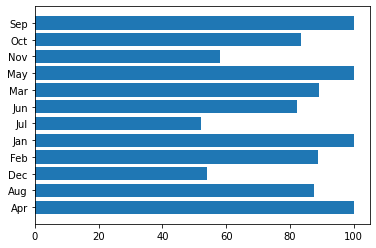

In [124]:
#Staff processing per month
import matplotlib.pyplot as plt
plt.barh(Output_chart["Month"], Output_chart["Percent Staff Appl"])

<BarContainer object of 12 artists>

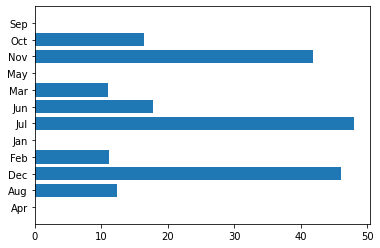

In [125]:
# Applications processed by only outsourced staff per month
plt.barh(Output_chart["Month"], Output_chart["Percent Outsource Appl"])

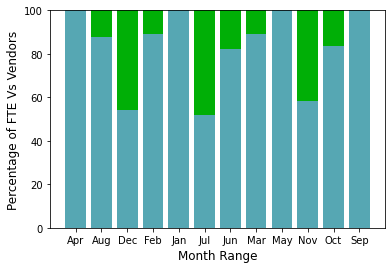

In [126]:
import matplotlib.pyplot as plt


figsize=(15, 16)
plt.bar(Output_chart["Month"], Output_chart["Percent Staff Appl"], color="#56a7b3")

plt.bar(Output_chart["Month"], Output_chart["Percent Outsource Appl"], bottom=Output_chart["Percent Staff Appl"], color="#00AF06")

plt.xlabel('Month Range', fontsize=12)  
plt.ylabel('Percentage of FTE Vs Vendors', fontsize=12)

plt.show()

### The above stacked chart clearly shows the %tage of applications processed by the Staff/Vendors per month.

#### Observations:

#### 1. Blue color shows applications processed by FTE
#### 2. Green color shows applications processed by Vendor
#### 3. Month like Jan, April, May,Sep --> 100% applications processed by FTE


#### Create a graph to show how the cost per application increases with respect to any change in the parameters in your analysis. Hint: Use the cost per application that you calculate in Questions 2 and 3 (i.e., the best case, and the worst case).

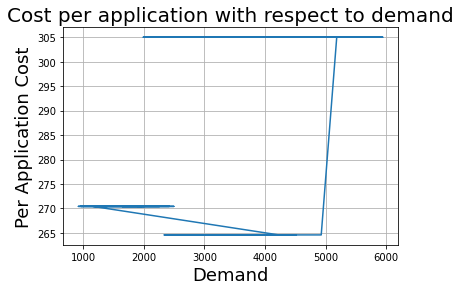

In [127]:
plt.plot(Output_ca['Demand'],Output_ca['Per Application Cost'])
plt.title('Cost per application with respect to demand', fontsize=20)
plt.xlabel('Demand', fontsize=18)
plt.ylabel('Per Application Cost', fontsize=18)
plt.grid(True)
plt.show()

#### The above graph is between demand and Cost per Application ( whether FTE/vendor any one processes it)
Also, There is no impact of any change in parameters.
#### Graph is always increasing in nature


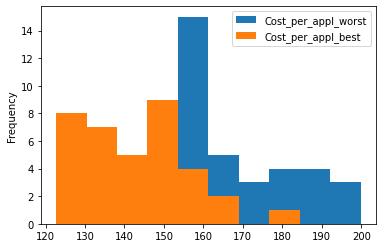

In [128]:
figsize=(20,20)
Output_ca.plot('Demand',['Cost_per_appl_worst','Cost_per_appl_best'], kind='hist')

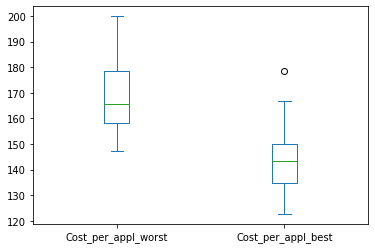

In [129]:
figsize=(20,20)
Output_ca.plot('Demand',['Cost_per_appl_worst','Cost_per_appl_best'], kind='box')

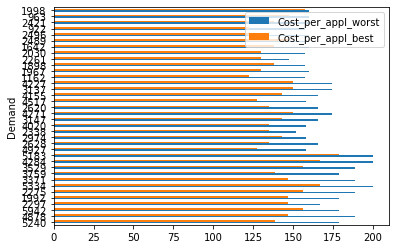

In [130]:
figsize=(60,50)
Output_ca.plot('Demand',['Cost_per_appl_worst','Cost_per_appl_best'], kind='barh')

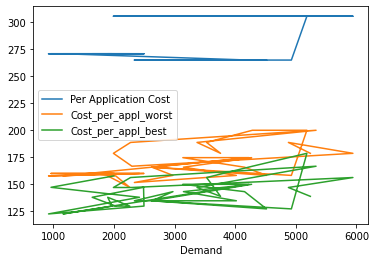

In [131]:
figsize=(20,20)
Output_ca.plot('Demand',['Per Application Cost','Cost_per_appl_worst','Cost_per_appl_best'], kind='line')

#### The above graph shows the different, best and worst case per application as per Q2.

#### Cost per application for worst scenario is represented by orange color.

#### Cost per application for best scenario is represented by green color.